# 1. Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms

from scipy.stats import skew, kurtosis


In [2]:
df = pd.read_csv('ab_test.csv', sep = ';')

# 2.1 Dataset Check and EDA

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
# Check if user_id is not repetitive
if df['user_id'].duplicated().any():
    print("Duplicates found in user_id. Dropping duplicates...")
    df = df.drop_duplicates(subset='userid')

In [5]:
# Set user_id as the index
df.set_index('user_id', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404770 entries, 1 to 404770
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   revenue    404770 non-null  int64 
 1   testgroup  404770 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.3+ MB


In [7]:
df.describe()

,revenue
count,404770.000000
mean,26.083435
std,681.652928
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,37433.000000


In [8]:
df.head()

,revenue,testgroup
user_id,,
1,0,b
2,0,a
3,0,a
4,0,b
5,0,b


In [9]:
# Descriptive statistics with skewness and kurtosis for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
descriptive_stats = df[numeric_cols].describe().T
descriptive_stats['skewness'] = df[numeric_cols].skew()
descriptive_stats['kurtosis'] = df[numeric_cols].kurtosis()
print("\nDescriptive Statistics (including skewness and kurtosis):")
print(descriptive_stats)


Descriptive Statistics (including skewness and kurtosis):
            count       mean         std  min  25%  50%  75%      max  \
revenue  404770.0  26.083435  681.652928  0.0  0.0  0.0  0.0  37433.0   

          skewness     kurtosis  
revenue  50.174637  2721.457746  


In [10]:
test_group_counts = df['testgroup'].value_counts(normalize = True) * 100

print("\nPercentage of each category in 'testgroup':")
print(test_group_counts)


Percentage of each category in 'testgroup':
testgroup
b    50.069669
a    49.930331
Name: proportion, dtype: float64


In [11]:
# Group by testgroup and calculate descriptive statistics for numeric columns
grouped_stats = df.groupby('testgroup')[numeric_cols].describe()

# Additional skewness and kurtosis by version
skewness_by_testgroup = df.groupby('testgroup')[numeric_cols].apply(lambda x: x.skew()).unstack()
kurtosis_by_testgroup = df.groupby('testgroup')[numeric_cols].apply(lambda x: x.kurtosis()).unstack()

# Combine descriptive statistics with skewness and kurtosis
grouped_stats = grouped_stats.unstack().T
grouped_stats['skewness'] = skewness_by_testgroup.T.values.flatten()
grouped_stats['kurtosis'] = kurtosis_by_testgroup.T.values.flatten()
grouped_stats = grouped_stats.reset_index()

print("\nDescriptive Statistics with Skewness and Kurtosis by testgroup:")
print(grouped_stats)


Descriptive Statistics with Skewness and Kurtosis by testgroup:
     level_0 level_1 testgroup                                         0
0    revenue   count         a                                  202103.0
1    revenue   count         b                                  202667.0
2    revenue    mean         a                                  25.41372
3    revenue    mean         b                                 26.751287
4    revenue     std         a                                920.768137
5    revenue     std         b                                287.324162
6    revenue     min         a                                       0.0
7    revenue     min         b                                       0.0
8    revenue     25%         a                                       0.0
9    revenue     25%         b                                       0.0
10   revenue     50%         a                                       0.0
11   revenue     50%         b                             

In [12]:
# Create a new categorical column for analysis
df['in_app_purchase'] = df['revenue'] > 0

In [13]:
# Cross-tabulation for version and retention_1
crosstab_in_app_purchase = pd.crosstab(df['testgroup'], df['in_app_purchase'], normalize='index')
crosstab_in_app_purchase.columns = ['Did not Pay', 'Paid']
crosstab_in_app_purchase = crosstab_in_app_purchase.reset_index()

In [14]:
iap_counts = df['in_app_purchase'].value_counts(normalize=True) * 100
print("\nPercentage of each category in 'in_app_purchase':")
print(iap_counts)


Percentage of each category in 'in_app_purchase':
in_app_purchase
False    99.077748
True      0.922252
Name: proportion, dtype: float64


Text(0, 0.5, 'In App Purchase Rate (%)')

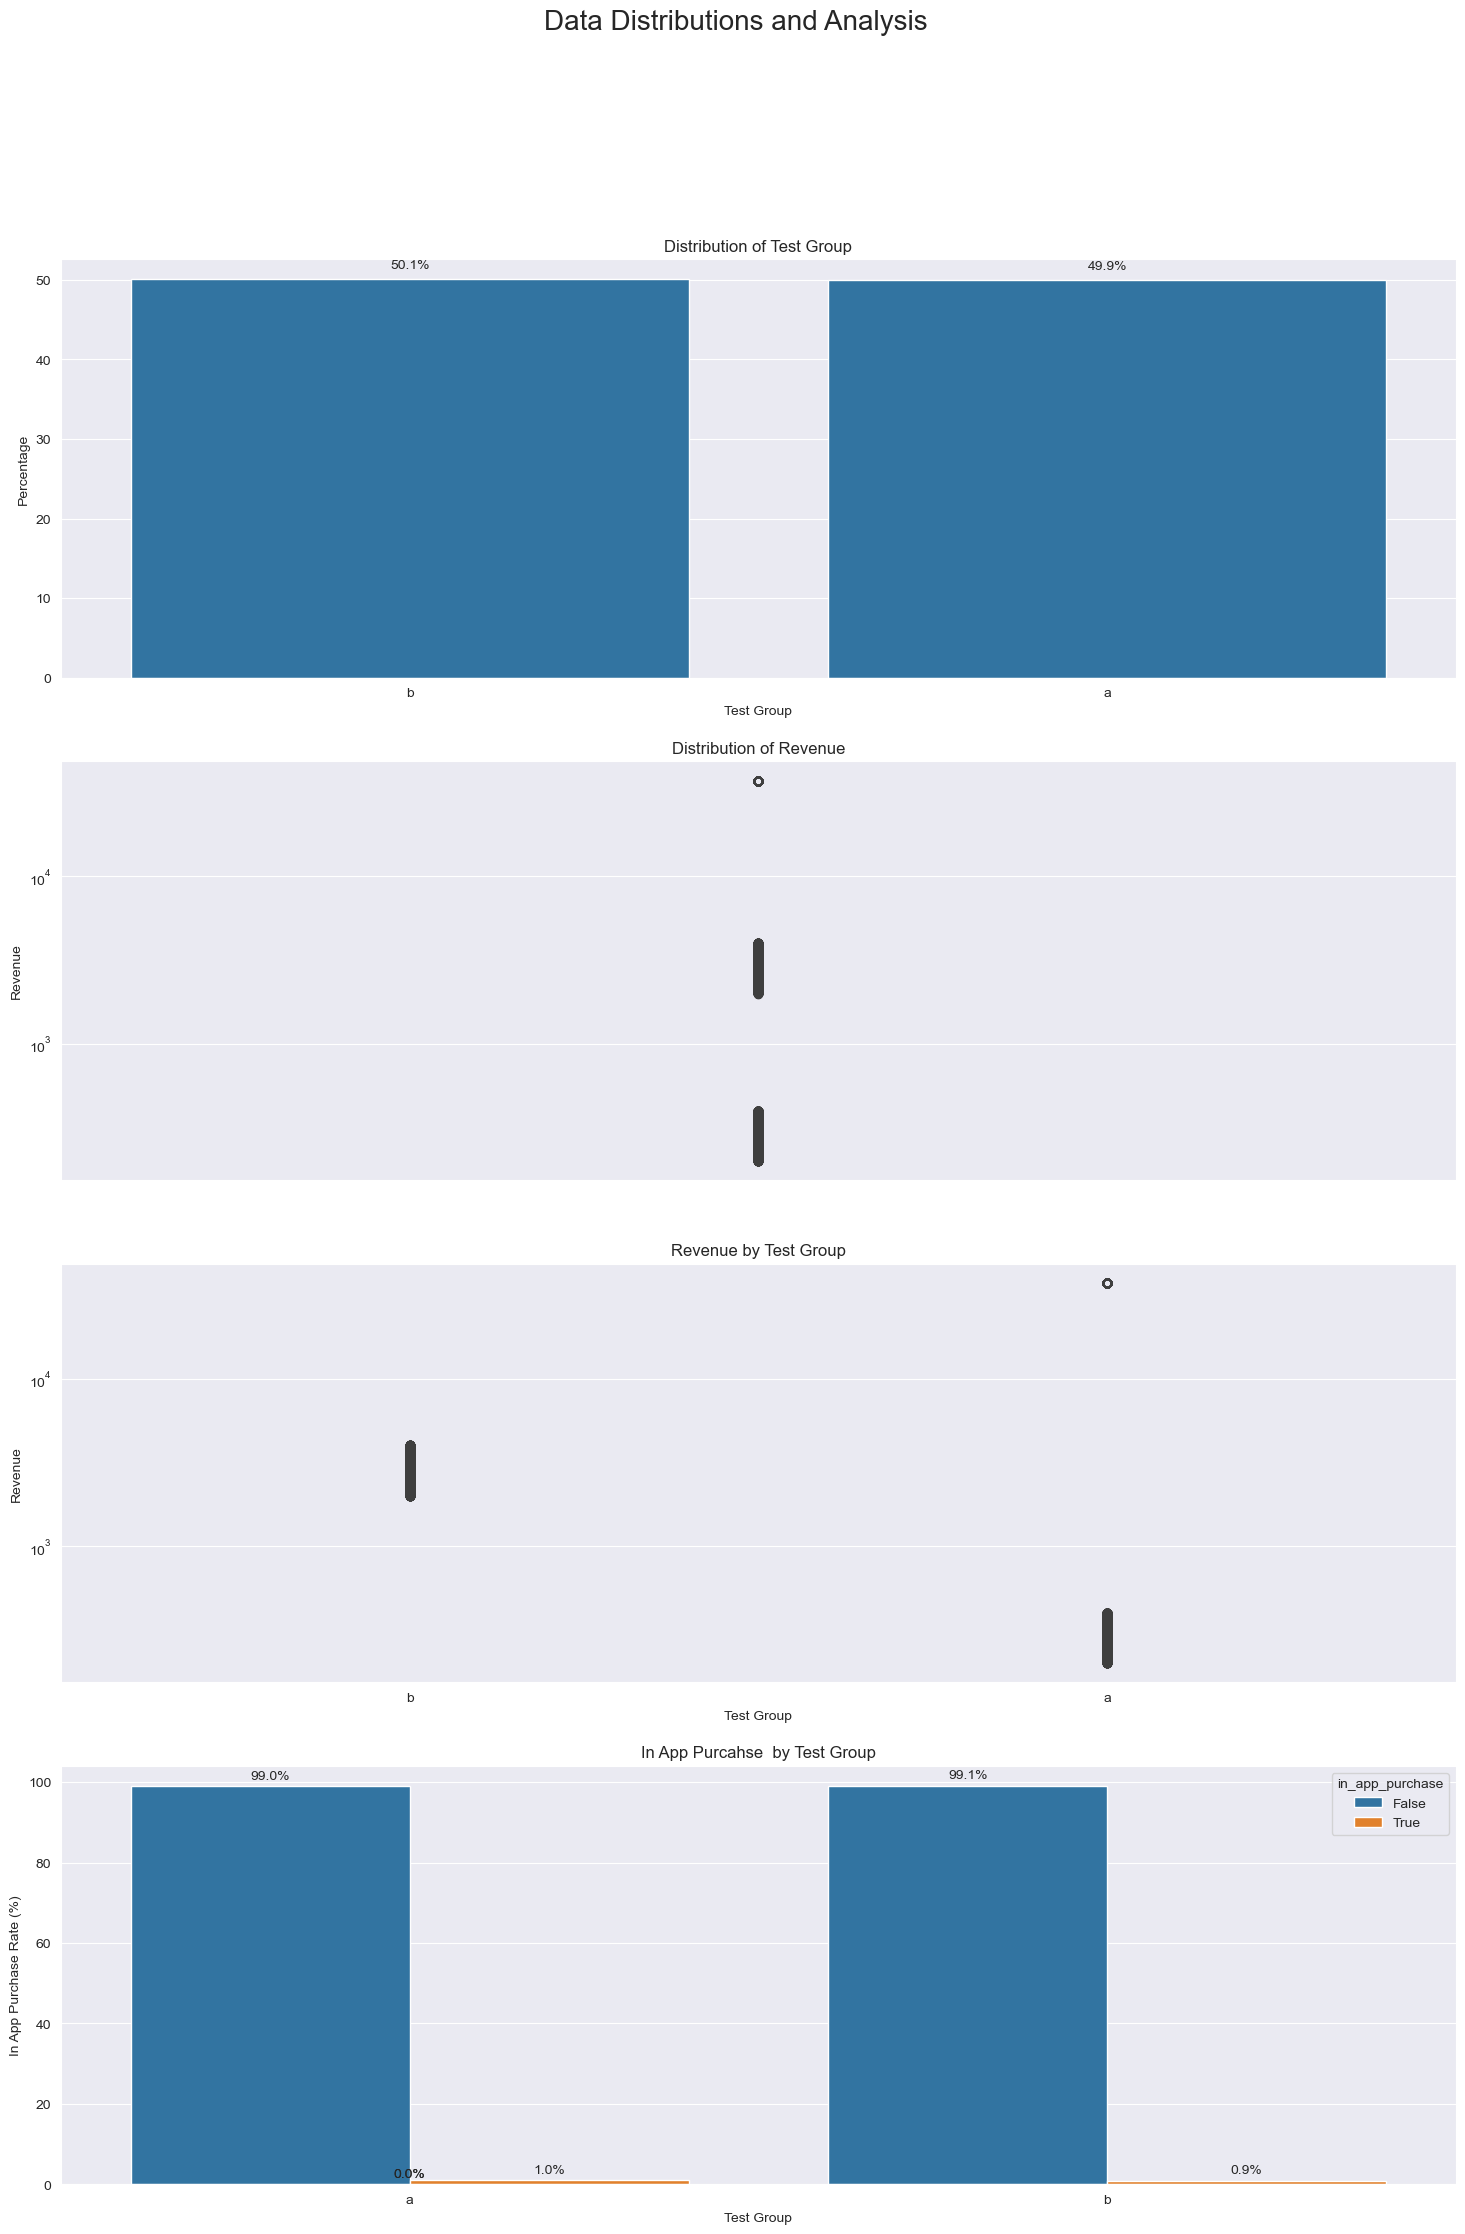

In [15]:
# Set the style for seaborn
sns.set_style("darkgrid")

fig, axes = plt.subplots(4, 1, figsize=(18, 25))
fig.suptitle('Data Distributions and Analysis', fontsize=20)

# Distribution of the 'test_group' column
sns.barplot(x=test_group_counts.index, y=test_group_counts.values, ax=axes[0])
axes[0].text(0, test_group_counts.values[0] + 1, f'{test_group_counts.values[0]:.1f}%', ha='center', va='bottom')
axes[0].text(1, test_group_counts.values[1] + 1, f'{test_group_counts.values[1]:.1f}%', ha='center', va='bottom')
axes[0].set_title('Distribution of Test Group')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Test Group')

# Distribution of 'revenue' as a box plot
sns.boxplot(ax=axes[1], y=df['revenue'])
axes[1].set_title('Distribution of Revenue')
axes[1].set_ylabel('Revenue')
axes[1].set_yscale('log')

# Analysis of revenue by testgroup
sns.boxplot(ax=axes[2], x='testgroup', y='revenue', data=df)
axes[2].set_title('Revenue by Test Group')
axes[2].set_xlabel('Test Group')
axes[2].set_ylabel('Revenue')
axes[2].set_yscale('log')

# Analysis of IAP by testgroup
in_app_purchase_by_testgroup = df.groupby(['testgroup', 'in_app_purchase']).size().reset_index(name='counts')
in_app_purchase_by_testgroup['percentage'] = in_app_purchase_by_testgroup['counts'] / in_app_purchase_by_testgroup.groupby('testgroup')['counts'].transform('sum') * 100
sns.barplot(ax=axes[3], x='testgroup', y='percentage', hue='in_app_purchase', data=in_app_purchase_by_testgroup)
for p in axes[3].patches:
    height = p.get_height()
    axes[3].text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center', va='bottom')
axes[3].set_title('In App Purcahse  by Test Group')
axes[3].set_xlabel('Test Group')
axes[3].set_ylabel('In App Purchase Rate (%)')

### Data Description and Findings

The dataset used in this analysis is 'ab_test.csv' from Kaggle page *Gamelytics: Mobile Analytics Challenge*. It contains two different test groups and their corrosponding revenue in game. Below is a detailed description of each column, including the data types and a brief explanation.

#### Columns:
1. **testgroup** (object)
- Indicates whether the user experienced the control or treatment feature of the game.
- Values: a (control), b (treatment)
- Distribution:
  - a (Control): 49.93%
  - b (Treatment): 50.07%
- The distribution of the testgroup column is nearly equal, making it suitable for A/B testing as it ensures a balanced comparison between the control and treatment groups.

2. **revenue** *(int)*

- Total revenue the game gained from the player.
- **Descriptive Statistics:**
  - Mean:26.083435
  - Standard Deviation: 681.652928
  - Minimum: 0.000000
  - 25th Percentile: 0.000000
  - Median:	0.000000
  - 75th Percentile: 0.000000
  - Maximum: 37433.000000
  - Skewness: 50.174637
  - Kurtosis: 2721.457746
- Insight
  - The distribution of the `revenue` column is highly skewed and has a high kurtosis value, indicating that most users almost never pay in the game while there are outliers pay a significantly larger amount of money.
 
3. **in_app_purchase** (bool)
- Indicates whether a player pays or not.
- Values: `True`, `False`
- Distribution:
  - True: 0.92%
  - False: 99.08%
- Insight
    - The distribution of `in_app_purchase` is highly unbalanced, with over 99% of players did not any in game.

#### Dataset Overview
- Total rows: 404, 770 

# 2.2 Define the Problem
The developers are planning to introduce a new feature in the mobile game as part of a limited-time event. Specifically, they are considering implementing a penalty mechanism where players will be penalized for failed attempts. 

The underlying idea is that by combining exclusive rewards with increased difficulty, players may feel more incentivized to complete the event—potentially leading to increased in-game spending.

**Objective 1**: Has the feature increased revenue by 10 dollars? 
- **Null Hypothsis(H0)**: The averge revenue in the treatment group has not increased by 10 compared to the control group
- **Alternative Hypothsis(Ha)**: The averge revenue in the treatment group has increased by 10 compared to the control group
  
**Objective 2**: Has the feature increased in-app purchase rate by 1%? 
- **Null Hypothsis(H0)**: The averge in-app purchase rate in the treatment group has not increased by 1% compared to the control group
- **Alternative Hypothsis(Ha)**: The averge in-app purchase rate in the treatment group has increased by 1% compared to the control group

# 3. Set the Significance Level and Power of the Test

In [29]:
# Define alpha, beta, and power
alpha = 0.05
beta = 0.20
power = 1 - beta

# 4.1 Calculate Sample Size and Choose Sample for Continuous A/B Test

In [30]:
# Separate control and treatment groups
control_group = df[df['testgroup'] == 'a']
treatment_group = df[df['testgroup'] == 'b']

In [31]:
# Define effect size for the continuous outcome
effect_size_revenue = 10  # Difference in average revenue

# Calculate the standard deviation of the revenue column
std_dev_revenue = df['revenue'].std()

# Calculate the required sample size for the continuous outcome using statsmodels
n_revenue = sms.NormalIndPower().solve_power(effect_size=effect_size_revenue / std_dev_revenue, power=power, alpha=alpha, ratio=1)

print(f"Required sample size for average number of game sessions test: {int(n_revenue)}")

Required sample size for average number of game sessions test: 72939


In [32]:
# Randomly select users for control and treatment groups based on the calculated sample size for revenue
control_revenue = control_group.sample(n=int(n_revenue), random_state=42)
treatment_revenue = treatment_group.sample(n=int(n_revenue), random_state=42)

# Verify the sample sizes
print(f"Sample size for control group (revenue): {len(control_revenue)}")
print(f"Sample size for treatment group (revenue): {len(treatment_revenue)}")

Sample size for control group (revenue): 72939
Sample size for treatment group (revenue): 72939


# 4.2 Calculate Sample Size and Choose Sample for Binary A/B Test

In [33]:
# Recompute crosstabs for iap by testgroup
crosstab_iap = pd.crosstab(df['testgroup'], df['in_app_purchase'], normalize='index')

# Extract baseline proportions from crosstab results
p1_iap = crosstab_iap.loc['a', True]

# Define expected improvements
p2_iap = p1_iap + 0.01  # 1% increase for IAP rate

# Define alpha, beta, and calculate power
alpha = 0.05
beta = 0.20
power = 1 - beta

# Calculate effect sizes and required sample sizes
effect_size_iap = sms.proportion_effectsize(p1_iap, p2_iap)
n_iap = sms.NormalIndPower().solve_power(effect_size=effect_size_iap, power=power, alpha=alpha, ratio=1)

required_sample_sizes = {
    "Required sample size for in-app pruchase test": int(n_iap),
}

required_sample_sizes

{'Required sample size for in-app pruchase test': 2181}

In [34]:
# Set random seed for reproducibility
np.random.seed(42)

# Randomly select users for control and treatment groups based on the calculated sample size for IAP
control_iap = control_group.sample(n=int(n_iap), random_state=42)
treatment_iap = treatment_group.sample(n=int(n_iap), random_state=42)

# Verify the sample sizes
print(f"Sample size for control group (IAP): {len(control_iap)}")
print(f"Sample size for treatment group (IAP): {len(treatment_iap)}")

Sample size for control group (IAP): 2181
Sample size for treatment group (IAP): 2181


# 5.1 Perform A/B Test for 'revenue'

In [35]:
from scipy.stats import ttest_ind, levene

# Define alpha
alpha = 0.05

# Calculate the means and standard deviations of the sum of game rounds in both groups
mean_control_gamerounds = control_revenue['revenue'].mean()
mean_treatment_gamerounds = treatment_revenue['revenue'].mean()
std_control_gamerounds = control_revenue['revenue'].std()
std_treatment_gamerounds = treatment_revenue['revenue'].std()

print(f"Control group - Mean: {mean_control_gamerounds}, Std Dev: {std_control_gamerounds}")
print(f"Treatment group - Mean: {mean_treatment_gamerounds}, Std Dev: {std_treatment_gamerounds}")

# Perform Levene's test for equality of variances
stat, p_levene = levene(control_revenue['revenue'], treatment_revenue['revenue'])

# Check if variances are equal
if p_levene < alpha:
    print("Assumption not met: The variances of the two groups are not equal. Switching to Welch's t-test.")
    equal_var = False
else:
    print("Assumption met: The variances of the two groups are equal.")
    equal_var = True

# Perform a one-tailed t-test directly comparing the two groups
t_stat_revenue, p_val_revenue = ttest_ind(treatment_revenue['revenue'], control_revenue['revenue'], equal_var=equal_var, alternative='greater')

# Print the results
print(f"T-statistic for revenue: {t_stat_revenue}")
print(f"P-value for revenue: {p_val_revenue}")

# Determine if the result is statistically significant
if p_val_revenue < alpha:
    print("Reject the null hypothesis: The average revenue in the treatment group is significantly greater than in the control group.")
else:
    print("Fail to reject the null hypothesis: The average revenue in the treatment group is not significantly greater than in the control group.")

Control group - Mean: 28.23270129834519, Std Dev: 977.130611885454
Treatment group - Mean: 26.918726607164892, Std Dev: 287.5511261870373
Assumption met: The variances of the two groups are equal.
T-statistic for revenue: -0.34840080798325485
P-value for revenue: 0.6362301507091461
Fail to reject the null hypothesis: The average revenue in the treatment group is not significantly greater than in the control group.


# 5.2 Perform A/B Test for 'in-app purchase'

In [39]:
from statsmodels.stats.proportion import proportions_ztest

# Define alpha 
alpha = 0.05

# Calculate the observed proportions of retention in both groups
p_control = control_iap['in_app_purchase'].mean()
p_treatment = treatment_iap['in_app_purchase'].mean()
n_control = len(control_iap)
n_treatment = len(treatment_iap)

# Ensure np and n(1-p) are greater than 5 for both groups
assumptions_met = True
if n_control * p_control <= 5:
    print("Assumption not met: np > 5 for control group")
    assumptions_met = False
if n_control * (1 - p_control) <= 5:
    print("Assumption not met: n(1-p) > 5 for control group")
    assumptions_met = False
if n_treatment * p_treatment <= 5:
    print("Assumption not met: np > 5 for treatment group")
    assumptions_met = False
if n_treatment * (1 - p_treatment) <= 5:
    print("Assumption not met: n(1-p) > 5 for treatment group")
    assumptions_met = False

if assumptions_met:
    print("All assumptions are met for the Z-test.")

    # Calculate the number of successes (retained users) and the number of trials (total users) in both groups
    successes_iap = [treatment_iap['in_app_purchase'].sum(), control_iap['in_app_purchase'].sum()]
    n_obs_iap = [len(treatment_iap), len(control_iap)]

    # Perform a one-tailed Z-test for proportions to check if the treatment is better than control
    z_stat_iap, p_val_iap = proportions_ztest(successes_iap, n_obs_iap, value=0, alternative='larger')
    
    # Print the results
    print(f"Z-statistic for IAP: {z_stat_iap}")
    print(f"P-value for IAP: {p_val_iap}")

    # Determine if the result is statistically significant
    if p_val_iap < alpha:
        print("Reject the null hypothesis: The in-app purchase rate has significantly increased.")
    else:
        print("Fail to reject the null hypothesis: The in-app purchase rate has not significantly increased.")
else:
    print("Z-test assumptions not met, cannot perform the test.")

All assumptions are met for the Z-test.
Z-statistic for IAP: -0.8215979628916257
P-value for IAP: 0.7943471254616273
Fail to reject the null hypothesis: The in-app purchase rate has not significantly increased.


# 6. Test Result Findings
#### Revenue (T-Test)

- **Objective:** Test if the average revenue from the treatment group is significantly greater than that from the control group.
- **Test Used:** One-tailed Two-Sample T-Test
- **T-statistic:** -0.34  
- **P-value:** 0.63

**Conclusion:**  
The p-value (0.63) is greater than the significance level α = 0.05.  
➡️ *Fail to reject the null hypothesis:*  
There is no statistically significant increase in average revenue in the treatment group compared to the control group.


#### In-App Purchase Rate (Z-Test for Proportions)

- **Objective:** Test if the proportion of users making in-app purchases is significantly higher in the treatment group.
- **Test Used:** One-tailed Z-Test for proportions
- **Z-statistic:** -0.82  
- **P-value:** 0.79

**Conclusion:**  
The p-value (0.79) is again greater than α = 0.05.  
➡️ *Fail to reject the null hypothesis:*  
There is no statistically significant increase in the in-app purchase rate in the treatment group.


### 🧾 Overall Summary

Despite the hypothesis that introducing a penalty mechanism would increase monetization through pressure and exclusivity, the A/B tests on both **revenue** and **in-app purchase rate** did **not show statistically significant improvements**. 

It is recommended to further explore:
- User segmentation (e.g., whales vs casual players)
- Longer observation windows
- Different implementation of challenge-reward balance
